In [1]:
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from decifer  import Tokenizer
import matplotlib.pyplot as plt

class HDF5Dataset(Dataset):
    def __init__(self, h5_file_path, data_to_load, block_size, numeric_padding_value=0):
        self.h5_file = h5py.File(h5_file_path, 'r')
        self.data_to_load = data_to_load
        self.block_size = block_size
        self.data = {key: self.h5_file[key] for key in self.data_to_load}
        
        self.token_padding_value = Tokenizer().padding_id
        self.numeric_padding_value = numeric_padding_value

    def __len__(self):
        total_chunks = 0
        for key in self.data_to_load:
            for sequence in self.data[key]:
                total_chunks += (len(sequence) + self.block_size - 1) // self.block_size
        return total_chunks

    def __getitem__(self, idx):
        sequence_chunks = self.find_sequence_and_chunk(idx)
        data = []
        block_size = self.block_size  # Cache the block size for faster access

        for key in self.data_to_load:
            sequence = self.data[key][sequence_chunks['sequence_idx']]
            chunk = None

            # Handle tokenized data
            if 'tokenized' in key:
                start = sequence_chunks['chunk_idx'] * block_size
                end = min(start + block_size, len(sequence))
                chunk = sequence[start:end]
            else:
                chunk = sequence

            # Handle numeric data (np.ndarray)
            if isinstance(chunk, np.ndarray):
                dtype = torch.float32 if 'float' in str(chunk.dtype) else torch.long
                chunk = torch.tensor(chunk, dtype=dtype)

            # Handle tokenized data (strings)
            elif isinstance(chunk, (bytes, str)):
                chunk = chunk.decode('utf-8') if isinstance(chunk, bytes) else chunk

            # Pad if necessary
            if isinstance(chunk, torch.Tensor) and len(chunk) < block_size:
                pad_value = self.token_padding_value if chunk.dtype == torch.long else self.numeric_padding_value
                chunk = torch.cat([chunk, torch.full((block_size - len(chunk),), pad_value, dtype=chunk.dtype)], dim=0)

            data.append(chunk)

        return tuple(data)

    def find_sequence_and_chunk(self, idx):
        total_chunks = 0
        for key in self.data_to_load:
            for i, sequence in enumerate(self.data[key]):
                num_chunks = (len(sequence) + self.block_size - 1) // self.block_size
                if idx < total_chunks + num_chunks:
                    chunk_idx = idx - total_chunks
                    return {'sequence_idx': i, 'chunk_idx': chunk_idx}
                total_chunks += num_chunks
        raise IndexError("Index out of bounds")

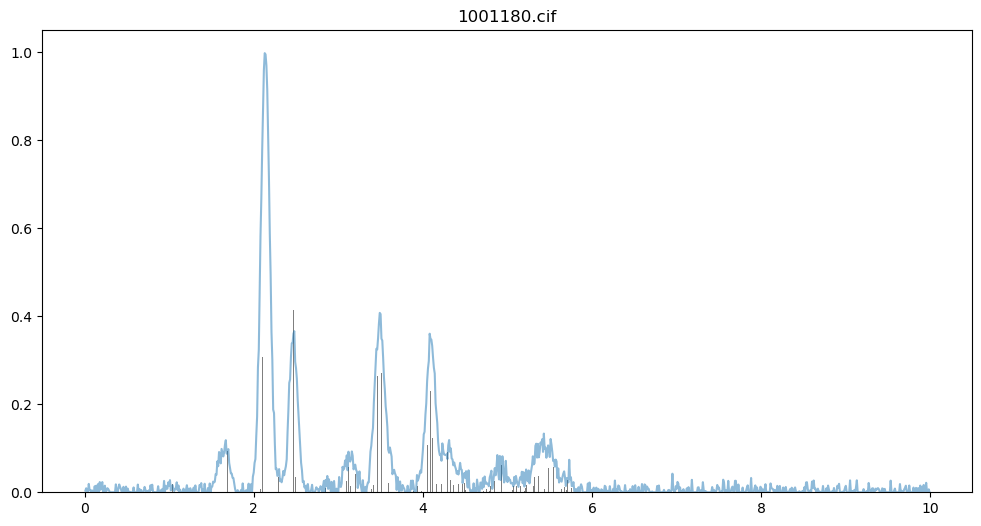

1.0396, 0.0197
1.3267, 0.0000
1.6009, 0.0827
1.6855, 0.0929
2.0792, 0.0078
2.1086, 0.3072
2.1450, 1.0000
2.2979, 0.0340
2.4664, 0.4135
2.4913, 0.0340
2.6534, 0.0025
2.8498, 0.0108
2.9140, 0.0116
3.0989, 0.0264
3.1188, 0.0570
3.1435, 0.0148
3.2018, 0.0407
3.3710, 0.0006
3.3892, 0.0070
3.4120, 0.0170
3.4658, 0.2653
3.5101, 0.2722
3.5969, 0.0212
3.6227, 0.0547
3.8338, 0.0010
3.8938, 0.0022
3.9411, 0.0148
3.9801, 0.0039
4.0568, 0.1079
4.0797, 0.0007
4.0948, 0.2293
4.1136, 0.1224
4.1584, 0.0185
4.2173, 0.0193
4.2900, 0.0913
4.3223, 0.0288
4.3649, 0.0163
4.4210, 0.0180
4.4697, 0.0189
4.4905, 0.0211
4.5042, 0.0045
4.5958, 0.0002
4.6624, 0.0131
4.7119, 0.0023
4.7510, 0.0065
4.7835, 0.0040
4.8027, 0.0145
4.8475, 0.0252
4.8667, 0.0011
4.9328, 0.0622
4.9794, 0.0003
4.9826, 0.0029
5.0565, 0.0053
5.0717, 0.0142
5.1081, 0.0140
5.1531, 0.0138
5.1980, 0.0029
5.2158, 0.0101
5.2276, 0.0157
5.3068, 0.0151
5.3212, 0.0336
5.3646, 0.0377
5.4077, 0.0747
5.4418, 0.0069
5.4869, 0.0558
5.5262, 0.0056
5.5430, 0.

In [5]:
tok = Tokenizer()

# Example usage:
block_size = 5000  # Transformer context length
dataset = HDF5Dataset('../data/chili100k/hdf5_data/train_dataset.h5', 
                      ['name', 'xrd_cont_x', 'xrd_cont_y', 'xrd_discrete_x', 
                       'xrd_discrete_y', 'xrd_tokenized', 'cif_tokenized', 'cif_content']
                      , block_size)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


for batch in dataloader:
    for ni, x, y, xd, yd, xrd_tokens, cif_tokens, cif_content in zip(*batch):
        plt.figure(figsize=(12,6))
        plt.title(ni)
        plt.bar(xd,yd, width=0.01, color='k', alpha=0.5)
        plt.plot(x[x!=0],y[x != 0], alpha=0.5)
        plt.show()
        xrd_tokens = xrd_tokens[xrd_tokens != tok.padding_id]
        print(tok.decode(list(xrd_tokens.numpy())))
        cif_tokens = cif_tokens[cif_tokens != tok.padding_id]
        print(tok.decode(list(cif_tokens.numpy())))
        break
    break

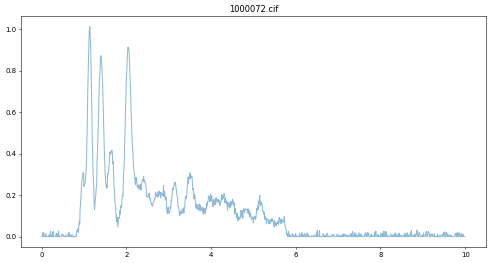

data_VPO7
_symmetry_space_group_name_H-M   P-1
_cell_length_a   5.6590
_cell_length_b   7.5780
_cell_length_c   12.6230
_cell_angle_alpha   89.6600
_cell_angle_beta   77.8600
_cell_angle_gamma   87.7700
_symmetry_Int_Tables_number   2
_chemical_formula_structural   VPO7
_chemical_formula_sum   'V4 P4 O28'
_cell_volume   528.8155
_cell_formula_units_Z   4
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
V  V0  2  0.0913  0.2197  0.8621  1.0000
V  V1  2  0.1140  0.2762  0.3628  1.0000
P  P2  2  0.1530  0.1605  0.1070  1.0000
P  P3  2  0.1690  0.3440  0.6101  1.0000
O  O4  2  0.0370  0.2690  0.7130  1.0000
O  O5  2  0.0410  0.2370  0.0230  1.0000
O  O6  2  0.0420  0.2670  0.2190  1.0000
O  O7  2  0.1180  0.2290  0.5090  1.0000
O  O8  2  0.1400  0.5430  0.5976  1.0000
O  O9  2  0.1420  0.9620  0.1211  1.0000
O 

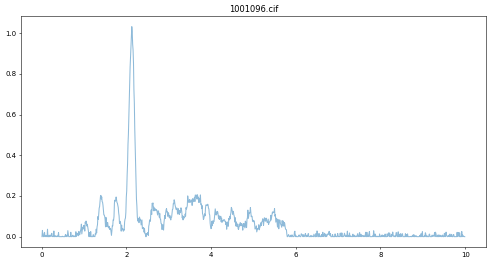

data_Y3ReO8
_symmetry_space_group_name_H-M   P2_1/c
_cell_length_a   7.1960
_cell_length_b   6.0450
_cell_length_c   14.3910
_cell_angle_alpha   90.0000
_cell_angle_beta   112.0800
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   14
_chemical_formula_structural   Y3ReO8
_chemical_formula_sum   'Y12 Re4 O32'
_cell_volume   580.0946
_cell_formula_units_Z   4
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Y  Y0  4  0.0917  0.1571  0.6684  1.0000
Y  Y1  4  0.3507  0.7235  0.5505  1.0000
Y  Y2  4  0.4032  0.7447  0.8029  1.0000
Re  Re3  4  0.1785  0.2329  0.9126  1.0000
O  O4  4  0.0089  0.1826  0.4742  1.0000
O  O5  4  0.0403  0.7078  0.2174  1.0000
O  O6  4  0.0986  0.5618  0.4115  1.0000
O  O7  4  0.2707  0.5342  0.9058  1.0000
O  O8  4  0.2968  0.0179  0.1709  1.0000
O  O9  4  0.3266  0.1380  0.83

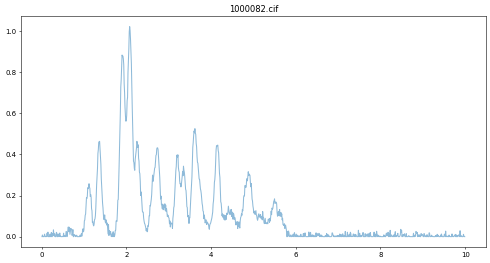

data_Rb2NaAl6F21
_symmetry_space_group_name_H-M   C2
_cell_length_a   12.0750
_cell_length_b   6.9720
_cell_length_c   10.2140
_cell_angle_alpha   90.0000
_cell_angle_beta   113.2000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   5
_chemical_formula_structural   Rb2NaAl6F21
_chemical_formula_sum   'Rb4 Na2 Al12 F42'
_cell_volume   790.3507
_cell_formula_units_Z   2
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Rb  Rb0  4  0.1343  -0.0000  0.4048  1.0000
Na  Na1  2  0.0000  0.4844  0.5000  1.0000
Al  Al2  4  0.0644  0.4768  0.1916  1.0000
Al  Al3  4  0.1862  0.7287  0.8085  1.0000
Al  Al4  4  0.1863  0.2279  0.8106  1.0000
F  F5  4  0.0376  0.6622  0.7944  1.0000
F  F6  4  0.0489  0.2958  0.8329  1.0000
F  F7  4  0.1172  0.2389  0.6258  1.0000
F  F8  4  0.1226  0.4410  0.3741  1.0000
F  F9  4  

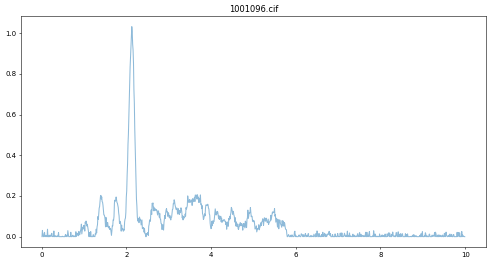

data_Y3ReO8
_symmetry_space_group_name_H-M   P2_1/c
_cell_length_a   7.1960
_cell_length_b   6.0450
_cell_length_c   14.3910
_cell_angle_alpha   90.0000
_cell_angle_beta   112.0800
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   14
_chemical_formula_structural   Y3ReO8
_chemical_formula_sum   'Y12 Re4 O32'
_cell_volume   580.0946
_cell_formula_units_Z   4
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Y  Y0  4  0.0917  0.1571  0.6684  1.0000
Y  Y1  4  0.3507  0.7235  0.5505  1.0000
Y  Y2  4  0.4032  0.7447  0.8029  1.0000
Re  Re3  4  0.1785  0.2329  0.9126  1.0000
O  O4  4  0.0089  0.1826  0.4742  1.0000
O  O5  4  0.0403  0.7078  0.2174  1.0000
O  O6  4  0.0986  0.5618  0.4115  1.0000
O  O7  4  0.2707  0.5342  0.9058  1.0000
O  O8  4  0.2968  0.0179  0.1709  1.0000
O  O9  4  0.3266  0.1380  0.83

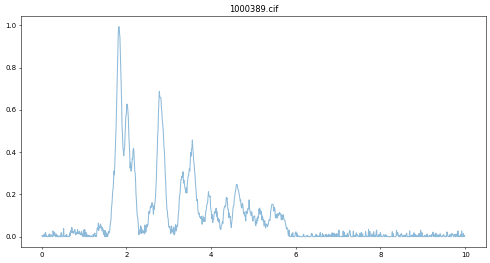

data_Ba2Zn2ClF7
_symmetry_space_group_name_H-M   P2_1/m
_cell_length_a   7.7000
_cell_length_b   5.8010
_cell_length_c   8.9390
_cell_angle_alpha   90.0000
_cell_angle_beta   106.8500
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   11
_chemical_formula_structural   Ba2Zn2ClF7
_chemical_formula_sum   'Ba4 Zn4 Cl2 F14'
_cell_volume   382.1420
_cell_formula_units_Z   2
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Ba  Ba0  2  0.3047  0.2500  0.0750  1.0000
Ba  Ba1  2  0.3317  0.2500  0.5871  1.0000
Zn  Zn2  2  0.1726  0.7500  0.2646  1.0000
Zn  Zn3  2  0.1816  0.7500  0.8268  1.0000
Cl  Cl4  2  0.1175  0.7500  0.5299  1.0000
F  F5  4  0.0052  0.0002  0.8274  1.0000
F  F6  4  0.3603  0.5028  0.3448  1.0000
F  F7  4  0.3698  0.5072  0.8392  1.0000
F  F8  2  0.2527  0.7500  0.0654  1.0000


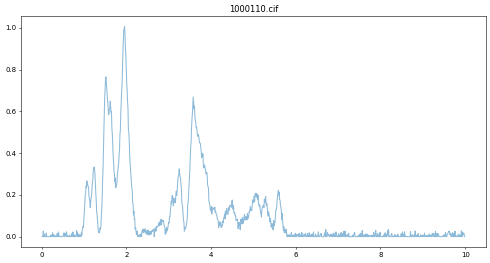

data_AlF3
_symmetry_space_group_name_H-M   P4/nmm
_cell_length_a   10.1843
_cell_length_b   10.1843
_cell_length_c   7.1738
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   129
_chemical_formula_structural   AlF3
_chemical_formula_sum   'Al16 F48'
_cell_volume   744.0663
_cell_formula_units_Z   16
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Al  Al0  8  0.0000  0.1635  0.6713  1.0000
Al  Al1  4  0.2500  0.2500  0.0000  1.0000
Al  Al2  2  0.0000  0.5000  0.0918  1.0000
Al  Al3  2  0.0000  0.5000  0.5879  1.0000
F  F4  16  0.1284  0.1976  0.8390  1.0000
F  F5  8  0.0000  0.3281  0.5895  1.0000
F  F6  8  0.1233  0.1233  0.5000  1.0000
F  F7  8  0.1285  0.3715  0.0911  1.0000
F  F8  4  0.0000  0.0000  0.2442  1.0000
F  F9  2  0.0000  0.5000  0.

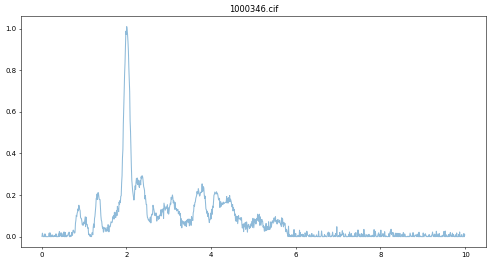

data_V6Fe4(CuO8)3
_symmetry_space_group_name_H-M   P-1
_cell_length_a   6.6000
_cell_length_b   8.0480
_cell_length_c   9.7590
_cell_angle_alpha   106.0800
_cell_angle_beta   103.7200
_cell_angle_gamma   102.2800
_symmetry_Int_Tables_number   2
_chemical_formula_structural   V6Fe4(CuO8)3
_chemical_formula_sum   'V6 Fe4 Cu3 O24'
_cell_volume   461.8553
_cell_formula_units_Z   1
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
V  V0  2  0.1083  0.1002  0.3356  1.0000
V  V1  2  0.2208  0.6546  0.2699  1.0000
V  V2  2  0.4097  0.7319  0.8764  1.0000
Fe  Fe3  2  0.0410  0.2035  0.0091  1.0000
Fe  Fe4  2  0.3805  0.9487  0.6078  1.0000
Cu  Cu5  2  0.2774  0.2915  0.7907  1.0000
Cu  Cu6  1  0.0000  0.5000  0.5000  1.0000
O  O7  2  0.0040  0.7157  0.1681  1.0000
O  O8  2  0.0778  0.0591  0.1444  1.0000
O  O9  2  0.

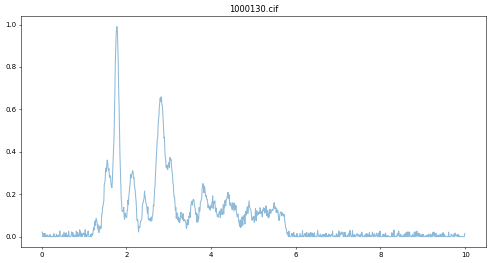

data_BaAlF5
_symmetry_space_group_name_H-M   P2_1/c
_cell_length_a   5.1517
_cell_length_b   19.5666
_cell_length_c   8.9637
_cell_angle_alpha   90.0000
_cell_angle_beta   122.6186
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   14
_chemical_formula_structural   BaAlF5
_chemical_formula_sum   'Ba8 Al8 F40'
_cell_volume   761.0417
_cell_formula_units_Z   8
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Ba  Ba0  4  0.2183  0.7300  0.4743  1.0000
Ba  Ba1  4  0.4580  0.5389  0.2400  1.0000
Al  Al2  4  0.0819  0.1075  0.8495  1.0000
Al  Al3  4  0.2820  0.1320  0.5280  1.0000
F  F4  4  0.0308  0.1983  0.8174  1.0000
F  F5  4  0.0659  0.1159  0.0433  1.0000
F  F6  4  0.0885  0.6511  0.1469  1.0000
F  F7  4  0.0962  0.0998  0.6506  1.0000
F  F8  4  0.1275  0.0170  0.8805  1.0000
F  F9  4  0.2083  0.0457

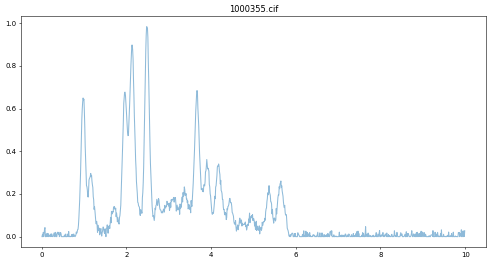

data_CrCu(PS3)2
_symmetry_space_group_name_H-M   Pc
_cell_length_a   5.9350
_cell_length_b   10.2820
_cell_length_c   13.3680
_cell_angle_alpha   90.0000
_cell_angle_beta   106.7800
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   7
_chemical_formula_structural   CrCu(PS3)2
_chemical_formula_sum   'Cr4 Cu4 P8 S24'
_cell_volume   781.0294
_cell_formula_units_Z   4
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Cr  Cr0  2  0.0000  0.3320  0.2500  1.0000
Cr  Cr1  2  0.5270  0.1700  0.7460  1.0000
Cu  Cu2  2  0.0710  0.0000  0.3550  1.0000
Cu  Cu3  2  0.4410  0.4960  0.1480  1.0000
P  P4  2  0.0790  0.3370  0.8270  1.0000
P  P5  2  0.4570  0.1630  0.1450  1.0000
P  P6  2  0.5450  0.1620  0.3170  1.0000
P  P7  2  0.9540  0.3320  0.6540  1.0000
S  S8  2  0.2300  0.3160  0.1260  1.0000
S  S9  2  0.2470 

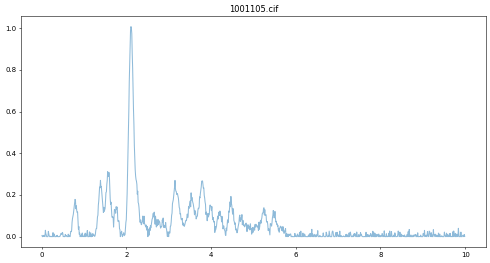

data_K3Nb3Si2O13
_symmetry_space_group_name_H-M   P-62m
_cell_length_a   9.0320
_cell_length_b   9.0320
_cell_length_c   8.0410
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   120.0000
_symmetry_Int_Tables_number   189
_chemical_formula_structural   K3Nb3Si2O13
_chemical_formula_sum   'K6 Nb6 Si4 O26'
_cell_volume   568.0788
_cell_formula_units_Z   2
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
K  K0  3  0.0000  0.5910  0.5000  1.0000
K  K1  3  0.0000  0.6040  0.0000  1.0000
Nb  Nb2  6  0.0000  0.2390  0.2340  1.0000
Si  Si3  4  0.3333  0.6667  0.2030  1.0000
O  O4  12  0.1760  0.4940  0.2650  1.0000
O  O5  6  0.0000  0.8160  0.2370  1.0000
O  O6  3  0.0000  0.2500  0.0000  1.0000
O  O7  3  0.0000  0.2680  0.5000  1.0000
O  O8  2  0.3333  0.6667  0.0000  1.0000


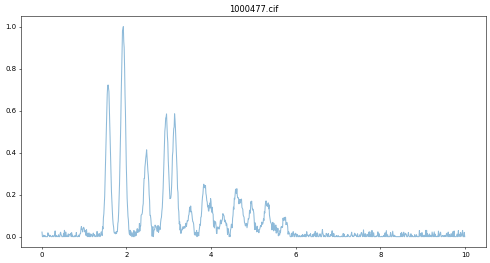

data_Ba2CeC3O9F
_symmetry_space_group_name_H-M   P2_1/m
_cell_length_a   6.6380
_cell_length_b   5.0970
_cell_length_c   13.1317
_cell_angle_alpha   90.0000
_cell_angle_beta   102.5496
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   11
_chemical_formula_structural   Ba2CeC3O9F
_chemical_formula_sum   'Ba4 Ce2 C6 O18 F2'
_cell_volume   433.6805
_cell_formula_units_Z   2
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Ba  Ba0  2  0.2152  0.7500  0.9249  1.0000
Ba  Ba1  2  0.2740  0.7500  0.5834  1.0000
Ce  Ce2  2  0.2268  0.7500  0.2387  1.0000
C  C3  2  0.2143  0.2500  0.7267  1.0000
C  C4  2  0.2543  0.2500  0.4278  1.0000
C  C5  2  0.3316  0.2500  0.1276  1.0000
O  O6  4  0.1214  0.0332  0.7369  1.0000
O  O7  4  0.3221  0.0312  0.3981  1.0000
O  O8  4  0.4017  0.0294  0.1041  1.0000
O  O9  2  0.

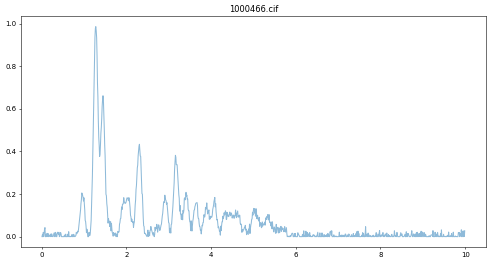

data_FeSnH12(OF)6
_symmetry_space_group_name_H-M   R-3
_cell_length_a   9.8260
_cell_length_b   9.8260
_cell_length_c   10.1060
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   120.0000
_symmetry_Int_Tables_number   148
_chemical_formula_structural   FeSnH12(OF)6
_chemical_formula_sum   'Fe3 Sn3 H36 O18 F18'
_cell_volume   845.0131
_cell_formula_units_Z   3
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Fe  Fe0  3  0.0000  0.0000  0.5000  1.0000
Sn  Sn1  3  0.0000  0.0000  0.0000  1.0000
H  H2  18  0.0100  0.1610  0.7290  1.0000
H  H3  18  0.0233  0.4437  0.2557  1.0000
O  O4  18  0.0139  0.1840  0.6187  1.0000
F  F5  18  0.0258  0.8540  0.1126  1.0000


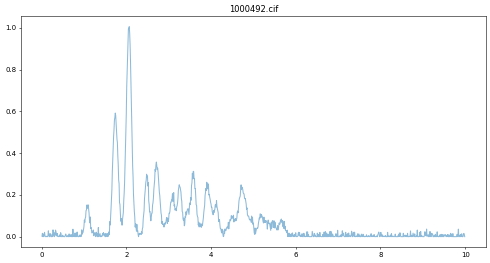

data_Cs2NaAl3F12
_symmetry_space_group_name_H-M   R-3m
_cell_length_a   7.0265
_cell_length_b   7.0265
_cell_length_c   18.2431
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   120.0000
_symmetry_Int_Tables_number   166
_chemical_formula_structural   Cs2NaAl3F12
_chemical_formula_sum   'Cs6 Na3 Al9 F36'
_cell_volume   780.0154
_cell_formula_units_Z   3
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Cs  Cs0  6  0.0000  0.0000  0.3788  1.0000
Na  Na1  3  0.0000  0.0000  0.0000  1.0000
Al  Al2  9  0.0000  0.5000  0.5000  1.0000
F  F3  18  0.0217  0.5108  0.5955  1.0000
F  F4  18  0.0843  0.5421  0.8389  1.0000


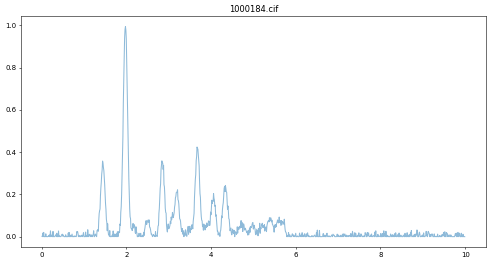

data_LiMnFeF6
_symmetry_space_group_name_H-M   P321
_cell_length_a   8.6840
_cell_length_b   8.6840
_cell_length_c   4.6570
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   120.0000
_symmetry_Int_Tables_number   150
_chemical_formula_structural   LiMnFeF6
_chemical_formula_sum   'Li3 Mn3 Fe3 F18'
_cell_volume   304.1421
_cell_formula_units_Z   3
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Li  Li0  2  0.3333  0.6667  0.5055  1.0000
Li  Li1  1  0.0000  0.0000  0.0000  1.0000
Mn  Mn2  3  0.0000  0.3545  0.0000  1.0000
Fe  Fe3  3  0.0000  0.6875  0.5000  1.0000
F  F4  6  0.1076  0.5765  0.7291  1.0000
F  F5  6  0.1085  0.8870  0.7565  1.0000
F  F6  6  0.2160  0.7786  0.2769  1.0000


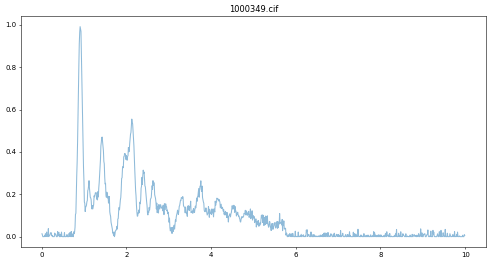

data_Ga8P8H35.44N7.44O36.56F4
_symmetry_space_group_name_H-M   P2_12_12_1
_cell_length_a   9.5930
_cell_length_b   9.7420
_cell_length_c   9.9810
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   19
_chemical_formula_structural   Ga8P8H35.44N7.44O36.56F4
_chemical_formula_sum   'Ga8 P8 H35.44 N7.44 O36.56 F4'
_cell_volume   932.7744
_cell_formula_units_Z   1
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Ga  Ga0  4  0.1011  0.2591  0.3584  1.0000
Ga  Ga1  4  0.1531  0.4806  0.8221  1.0000
P  P2  4  0.0761  0.4823  0.1372  1.0000
P  P3  4  0.0793  0.7970  0.8597  1.0000
H  H4  4  0.0040  0.0810  0.0040  0.9650
H  H5  4  0.0340  0.2190  0.0250  0.9650
H  H6  4  0.0440  0.6800  0.5850  0.9650
H  H7  4  0.1000  0.6700  0.4580  0.9650
H  H8  4  0.1

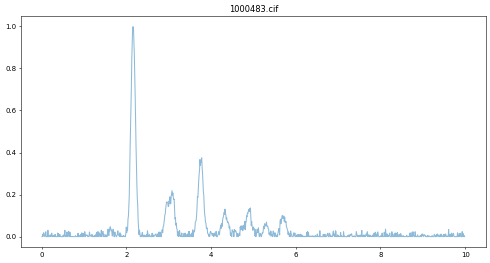

data_La2PdO4
_symmetry_space_group_name_H-M   I4/mmm
_cell_length_a   4.0550
_cell_length_b   4.0550
_cell_length_c   12.6200
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   139
_chemical_formula_structural   La2PdO4
_chemical_formula_sum   'La4 Pd2 O8'
_cell_volume   207.5110
_cell_formula_units_Z   2
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
La  La0  4  0.0000  0.0000  0.3510  1.0000
Pd  Pd1  2  0.0000  0.0000  0.0000  1.0000
O  O2  4  0.0000  0.5000  0.0000  1.0000
O  O3  4  0.0000  0.5000  0.2500  1.0000


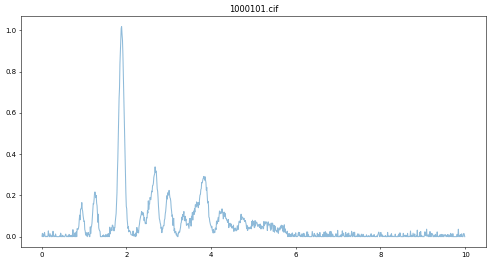

data_Co3(PO5)2
_symmetry_space_group_name_H-M   P2_1/c
_cell_length_a   7.5310
_cell_length_b   7.5160
_cell_length_c   7.3961
_cell_angle_alpha   90.0000
_cell_angle_beta   117.9004
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   14
_chemical_formula_structural   Co3(PO5)2
_chemical_formula_sum   'Co6 P4 O20'
_cell_volume   369.9782
_cell_formula_units_Z   2
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Co  Co0  4  0.2438  0.2266  0.5194  1.0000
Co  Co1  2  0.5000  0.0000  0.0000  1.0000
P  P2  4  0.2662  0.6170  0.7635  1.0000
O  O3  4  0.0910  0.7486  0.6063  1.0000
O  O4  4  0.1719  0.5293  0.8896  1.0000
O  O5  4  0.2485  0.1281  0.7745  1.0000
O  O6  4  0.3190  0.0138  0.1462  1.0000
O  O7  4  0.4435  0.7317  0.9003  1.0000


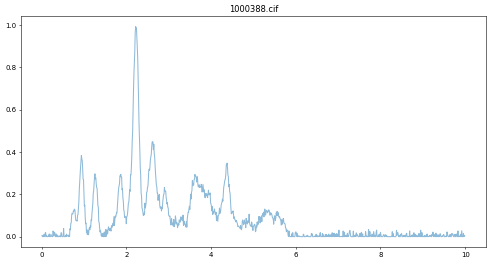

data_Ca11.2Tl8.8O24
_symmetry_space_group_name_H-M   Pbam
_cell_length_a   11.2480
_cell_length_b   16.5130
_cell_length_c   3.3329
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   55
_chemical_formula_structural   Ca11.2Tl8.8O24
_chemical_formula_sum   'Ca11.2 Tl8.8 O24'
_cell_volume   619.0466
_cell_formula_units_Z   1
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Ca  Ca0  4  0.1064  0.8548  0.5000  1.0000
Ca  Ca1  4  0.1349  0.4592  0.5000  0.9000
Tl  Tl2  4  0.1349  0.4592  0.5000  0.1000
Ca  Ca3  4  0.1703  0.2264  0.5000  0.9000
Tl  Tl4  4  0.1703  0.2264  0.5000  0.1000
Tl  Tl5  4  0.0852  0.6491  0.0000  1.0000
Tl  Tl6  4  0.1346  0.0457  0.0000  1.0000
O  O7  4  0.0460  0.3320  0.5000  1.0000
O  O8  4  0.0530  0.1570  0.0000  1.0000

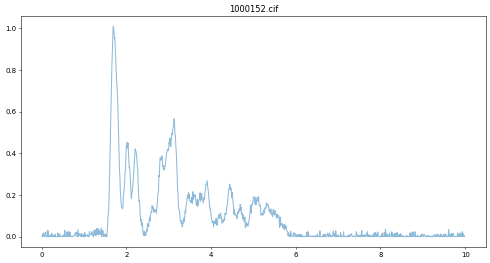

data_Ba2ZrF8
_symmetry_space_group_name_H-M   Pnma
_cell_length_a   9.7401
_cell_length_b   5.6167
_cell_length_c   11.8839
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   62
_chemical_formula_structural   Ba2ZrF8
_chemical_formula_sum   'Ba8 Zr4 F32'
_cell_volume   650.1351
_cell_formula_units_Z   4
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Ba  Ba0  4  0.0532  0.7500  0.6603  1.0000
Ba  Ba1  4  0.1376  0.7500  0.0596  1.0000
Zr  Zr2  4  0.2430  0.2500  0.8599  1.0000
F  F3  8  0.0937  0.5117  0.8639  1.0000
F  F4  8  0.1418  0.5134  0.4634  1.0000
F  F5  8  0.1557  0.5132  0.2544  1.0000
F  F6  4  0.1372  0.2500  0.6936  1.0000
F  F7  4  0.1491  0.2500  0.0284  1.0000


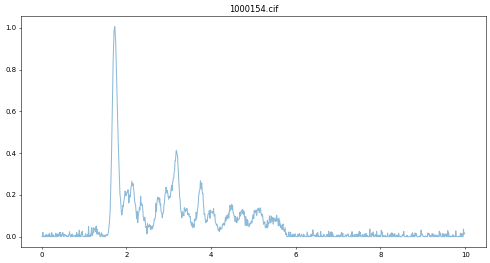

data_ZrPb2F8
_symmetry_space_group_name_H-M   Pnma
_cell_length_a   10.0800
_cell_length_b   5.3262
_cell_length_c   11.6637
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   62
_chemical_formula_structural   ZrPb2F8
_chemical_formula_sum   'Zr4 Pb8 F32'
_cell_volume   626.2018
_cell_formula_units_Z   4
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Zr  Zr0  4  0.2498  0.2500  0.8724  1.0000
Pb  Pb1  4  0.0430  0.7500  0.6565  1.0000
Pb  Pb2  4  0.1286  0.7500  0.0803  1.0000
F  F3  8  0.0888  0.0399  0.8776  1.0000
F  F4  8  0.1112  0.5002  0.4638  1.0000
F  F5  8  0.1310  0.5033  0.2677  1.0000
F  F6  4  0.1779  0.2500  0.7070  1.0000
F  F7  4  0.1870  0.2500  0.0455  1.0000


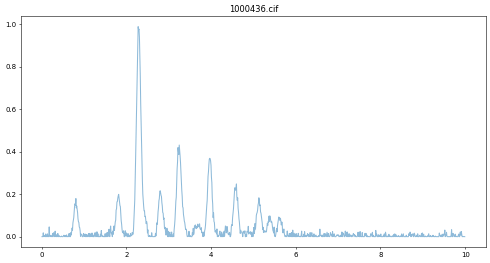

data_Li0.42La1.184Ti2O6
_symmetry_space_group_name_H-M   P4/mmm
_cell_length_a   3.8714
_cell_length_b   3.8714
_cell_length_c   7.7789
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   123
_chemical_formula_structural   Li0.42La1.184Ti2O6
_chemical_formula_sum   'Li0.42 La1.184 Ti2 O6'
_cell_volume   116.5881
_cell_formula_units_Z   1
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
La  La0  1  0.0000  0.0000  0.5000  0.3040
Li  Li1  1  0.0000  0.0000  0.5000  0.3600
La  La2  1  0.0000  0.0000  0.0000  0.8800
Li  Li3  1  0.0000  0.0000  0.0000  0.0600
Ti  Ti4  2  0.5000  0.5000  0.2678  1.0000
O  O5  4  0.0000  0.5000  0.2538  1.0000
O  O6  1  0.5000  0.5000  0.0000  1.0000
O  O7  1  0.5000  0.5000  0.5000  1.0000


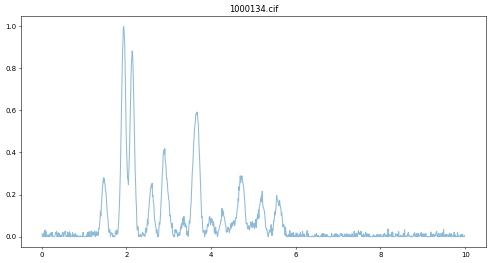

data_BaHgRuO5
_symmetry_space_group_name_H-M   P6_3/m
_cell_length_a   10.1760
_cell_length_b   10.1760
_cell_length_c   8.4121
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   120.0000
_symmetry_Int_Tables_number   176
_chemical_formula_structural   BaHgRuO5
_chemical_formula_sum   'Ba6 Hg6 Ru6 O30'
_cell_volume   754.3784
_cell_formula_units_Z   6
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Ba  Ba0  4  0.3333  0.6667  0.0165  1.0000
Ba  Ba1  2  0.0000  0.0000  0.0000  1.0000
Hg  Hg2  6  0.0120  0.6784  0.7500  1.0000
Ru  Ru3  6  0.0124  0.6694  0.2500  1.0000
O  O4  12  0.1140  0.7580  0.0930  1.0000
O  O5  6  0.1070  0.2290  0.7500  1.0000
O  O6  6  0.1200  0.5510  0.2500  1.0000
O  O7  6  0.1790  0.4920  0.7500  1.0000


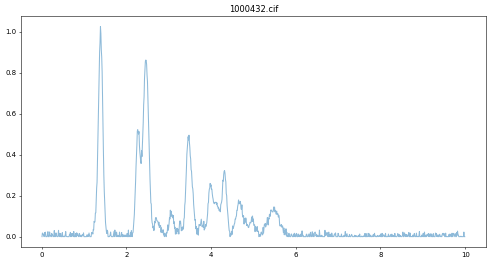

data_LiFeSnO4
_symmetry_space_group_name_H-M   Pnma
_cell_length_a   9.8740
_cell_length_b   3.0660
_cell_length_c   5.0660
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   62
_chemical_formula_structural   LiFeSnO4
_chemical_formula_sum   'Li2 Fe2 Sn2 O8'
_cell_volume   153.3665
_cell_formula_units_Z   2
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Li  Li0  4  0.0340  0.7500  0.4350  0.3800
Li  Li1  4  0.1050  0.2500  0.5280  0.1200
Fe  Fe2  4  0.1419  0.2500  0.9861  0.5000
Sn  Sn3  4  0.1419  0.2500  0.9861  0.5000
O  O4  4  0.0394  0.7500  0.7961  1.0000
O  O5  4  0.2172  0.7500  0.2076  1.0000


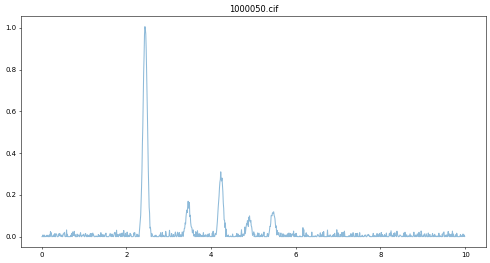

data_KCl
_symmetry_space_group_name_H-M   Pm-3m
_cell_length_a   3.6340
_cell_length_b   3.6340
_cell_length_c   3.6340
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   221
_chemical_formula_structural   KCl
_chemical_formula_sum   'K1 Cl1'
_cell_volume   47.9904
_cell_formula_units_Z   1
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
K  K0  1  0.0000  0.0000  0.0000  1.0000
Cl  Cl1  1  0.5000  0.5000  0.5000  1.0000


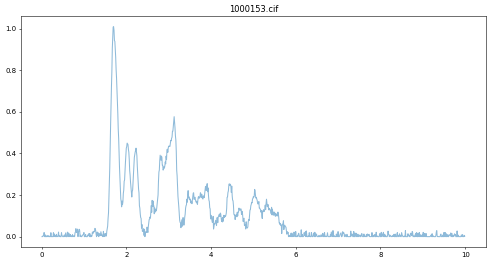

data_Ba2ZrF8
_symmetry_space_group_name_H-M   Pnma
_cell_length_a   9.7472
_cell_length_b   5.6173
_cell_length_c   11.8995
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   62
_chemical_formula_structural   Ba2ZrF8
_chemical_formula_sum   'Ba8 Zr4 F32'
_cell_volume   651.5327
_cell_formula_units_Z   4
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Ba  Ba0  4  0.0546  0.7500  0.6603  1.0000
Ba  Ba1  4  0.1387  0.7500  0.0593  1.0000
Zr  Zr2  4  0.2430  0.2500  0.8595  1.0000
F  F3  8  0.0966  0.5100  0.8623  1.0000
F  F4  8  0.1394  0.5189  0.4655  1.0000
F  F5  8  0.1577  0.5106  0.2543  1.0000
F  F6  4  0.1313  0.2500  0.6911  1.0000
F  F7  4  0.1495  0.2500  0.0304  1.0000


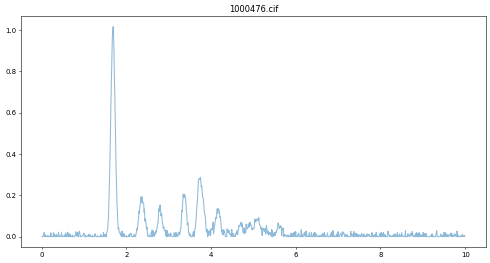

data_FeF3
_symmetry_space_group_name_H-M   R-3c
_cell_length_a   5.1942
_cell_length_b   5.1942
_cell_length_c   13.3349
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   120.0000
_symmetry_Int_Tables_number   167
_chemical_formula_structural   FeF3
_chemical_formula_sum   'Fe6 F18'
_cell_volume   311.5709
_cell_formula_units_Z   6
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Fe  Fe0  6  0.0000  0.0000  0.0000  1.0000
F  F1  18  0.0000  0.4107  0.2500  1.0000


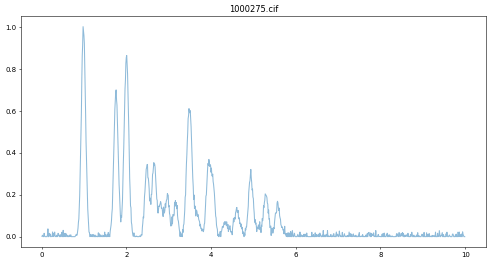

data_Rb0.12Al4H15.52N3.88F16
_symmetry_space_group_name_H-M   P4_2/mbc
_cell_length_a   5.0569
_cell_length_b   5.0569
_cell_length_c   12.7091
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   135
_chemical_formula_structural   Rb0.12Al4H15.52N3.88F16
_chemical_formula_sum   'Rb0.12 Al4 H15.52 N3.88 F16'
_cell_volume   325.0001
_cell_formula_units_Z   1
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Al  Al0  4  0.0000  0.5000  0.0000  1.0000
H  H1  16  0.0004  0.1705  0.2036  0.9700
Rb  Rb2  4  0.0000  0.0000  0.2500  0.0300
N  N3  4  0.0000  0.0000  0.2500  0.9700
F  F4  8  0.0000  0.5000  0.1389  1.0000
F  F5  8  0.2034  0.2063  0.5000  1.0000


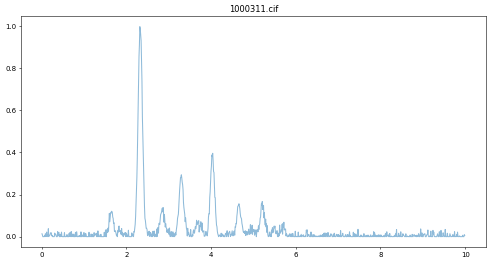

data_PrNiO3
_symmetry_space_group_name_H-M   Pnma
_cell_length_a   5.3884
_cell_length_b   7.6164
_cell_length_c   5.4155
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   62
_chemical_formula_structural   PrNiO3
_chemical_formula_sum   'Pr4 Ni4 O12'
_cell_volume   222.2533
_cell_formula_units_Z   4
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Pr  Pr0  4  0.0329  0.7500  0.9939  1.0000
Ni  Ni1  4  0.0000  0.0000  0.5000  1.0000
O  O2  8  0.2180  0.0372  0.2181  1.0000
O  O3  4  0.0075  0.2500  0.5704  1.0000


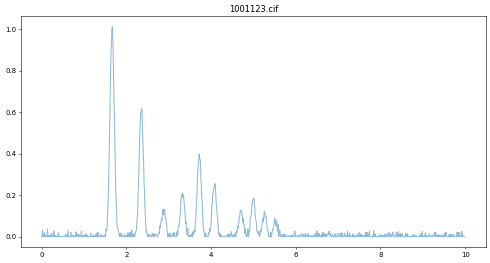

data_Y0.06Ta0.18W0.82O3
_symmetry_space_group_name_H-M   Pm-3m
_cell_length_a   3.7742
_cell_length_b   3.7742
_cell_length_c   3.7742
_cell_angle_alpha   90.0000
_cell_angle_beta   90.0000
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   221
_chemical_formula_structural   Y0.06Ta0.18W0.82O3
_chemical_formula_sum   'Y0.06 Ta0.18 W0.82 O3'
_cell_volume   53.7615
_cell_formula_units_Z   1
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Y  Y0  1  0.0000  0.0000  0.0000  0.0600
Ta  Ta1  1  0.5000  0.5000  0.5000  0.1800
W  W2  1  0.5000  0.5000  0.5000  0.8200
O  O3  3  0.0000  0.5000  0.5000  1.0000


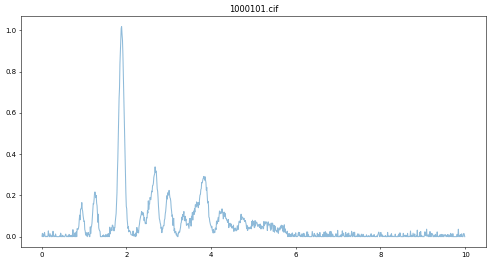

data_Co3(PO5)2
_symmetry_space_group_name_H-M   P2_1/c
_cell_length_a   7.5310
_cell_length_b   7.5160
_cell_length_c   7.3961
_cell_angle_alpha   90.0000
_cell_angle_beta   117.9004
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   14
_chemical_formula_structural   Co3(PO5)2
_chemical_formula_sum   'Co6 P4 O20'
_cell_volume   369.9782
_cell_formula_units_Z   2
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Co  Co0  4  0.2438  0.2266  0.5194  1.0000
Co  Co1  2  0.5000  0.0000  0.0000  1.0000
P  P2  4  0.2662  0.6170  0.7635  1.0000
O  O3  4  0.0910  0.7486  0.6063  1.0000
O  O4  4  0.1719  0.5293  0.8896  1.0000
O  O5  4  0.2485  0.1281  0.7745  1.0000
O  O6  4  0.3190  0.0138  0.1462  1.0000
O  O7  4  0.4435  0.7317  0.9003  1.0000


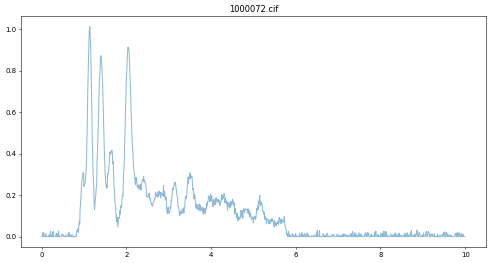

data_VPO7
_symmetry_space_group_name_H-M   P-1
_cell_length_a   5.6590
_cell_length_b   7.5780
_cell_length_c   12.6230
_cell_angle_alpha   89.6600
_cell_angle_beta   77.8600
_cell_angle_gamma   87.7700
_symmetry_Int_Tables_number   2
_chemical_formula_structural   VPO7
_chemical_formula_sum   'V4 P4 O28'
_cell_volume   528.8155
_cell_formula_units_Z   4
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
V  V0  2  0.0913  0.2197  0.8621  1.0000
V  V1  2  0.1140  0.2762  0.3628  1.0000
P  P2  2  0.1530  0.1605  0.1070  1.0000
P  P3  2  0.1690  0.3440  0.6101  1.0000
O  O4  2  0.0370  0.2690  0.7130  1.0000
O  O5  2  0.0410  0.2370  0.0230  1.0000
O  O6  2  0.0420  0.2670  0.2190  1.0000
O  O7  2  0.1180  0.2290  0.5090  1.0000
O  O8  2  0.1400  0.5430  0.5976  1.0000
O  O9  2  0.1420  0.9620  0.1211  1.0000
O 

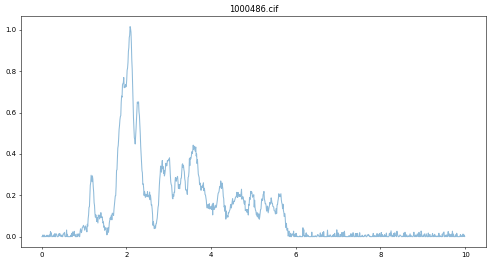

data_Sr4Ga2P4H(O4F)4
_symmetry_space_group_name_H-M   P2_1/c
_cell_length_a   8.2570
_cell_length_b   7.2050
_cell_length_c   13.5489
_cell_angle_alpha   90.0000
_cell_angle_beta   107.3974
_cell_angle_gamma   90.0000
_symmetry_Int_Tables_number   14
_chemical_formula_structural   Sr4Ga2P4H(O4F)4
_chemical_formula_sum   'Sr8 Ga4 P8 H2 O32 F8'
_cell_volume   769.1738
_cell_formula_units_Z   2
loop_
_symmetry_equiv_pos_site_id
_symmetry_equiv_pos_as_xyz
1  'x, y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Sr  Sr0  4  0.1252  0.6710  0.4227  1.0000
Sr  Sr1  4  0.3317  0.1687  0.5514  1.0000
Ga  Ga2  4  0.2703  0.0054  0.2908  1.0000
P  P3  4  0.0376  0.6988  0.1305  1.0000
P  P4  4  0.4906  0.1150  0.8463  1.0000
H  H5  2  0.0000  0.0000  0.0000  1.0000
O  O6  4  0.0533  0.1601  0.9526  1.0000
O  O7  4  0.0996  0.0605  0.3591  1.0000
O  O8  4  0.1176  0.7027  0.7350  1.0000

In [4]:
tok = Tokenizer()

# Example usage:
block_size = 128  # Transformer context length
dataset = HDF5Dataset('../data/chili100k/hdf5_data/train_dataset.h5', 
                      ['name', 'xrd_cont_x', 'xrd_cont_y', 'xrd_tokenized', 'cif_tokenized', 'cif_content'], block_size)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


for batch in dataloader:
    for ni, x, y, xrd_tokens, cif_tokens, cif_content in zip(*batch):
        plt.figure(figsize=(12,6), dpi=50)
        plt.title(ni)
        plt.plot(x[x!=0],y[x != 0], alpha=0.5)
        plt.show()
        print(cif_content)
    break